# notebook imagenette
The basis is kaiming initialization and batchnorm

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [3]:
from lib.callbacks import *
from lib.model import *
from lib.data import *
from lib.optimizers import *
from pathlib import Path

## Imagenette data

In [4]:
#path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path = Path("/Users/kasparlund/.fastai/data/imagenette-160")

In [6]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler)
out_features = max(ll.train.y)+1

train_dl,valid_dl = ( DataLoader(ll.train, batch_size=bs,   num_workers=4, shuffle=True),
                      DataLoader(ll.valid, batch_size=bs*2, num_workers=4))
data = DataBunch(train_dl, valid_dl)
print(len(train_dl))

101


In [8]:
layers_sizes = [32,64,128,256,512]

sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, partial(ParamScheduler, 'lr', sched),
        partial(BatchTransformXCallback, norm_imagenette),
        Recorder, partial(AvgStatsCallback,[accuracy]),
        #CudaCallback,
        ProgressCallback,
       ]

## steppers=[sgd_step]

In [ ]:
model = get_cnn_model(layers_sizes, 3, out_features, conv_layer) 
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, opt=sgd_opt(model.parameters(),lr=0.4, wd=0.01), cb_funcs=cbfs)
%time learn.fit(1)

In [ ]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## steppers=[weight_decay, sgd_step]

In [ ]:
model = get_cnn_model(layers_sizes, 3, out_features, conv_layer) 
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, opt=sgd_wd_opt(model.parameters(),lr=0.4, wd=0.01), 
                cb_funcs=cbfs)
print(opt.hypers[0]['lr']), print(opt.hypers[0]['wd'])
%time learn.fit(1)

In [ ]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## steppers=[weight_decay, sgd_step, l2_reg]

In [ ]:
model = get_cnn_model(layers_sizes, 3, out_features, conv_layer) 
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, opt=sgd_wd_l2_opt(model.parameters(),lr=0.4), cb_funcs=cbfs)
%time learn.fit(1)

In [ ]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## momentum: steppers=[momentum_step,weight_decay]

In [9]:
model = get_cnn_model(layers_sizes, 3, out_features, conv_layer) 
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, opt=sgd_mom_wd_opt(model.parameters(),lr=0.3), cb_funcs=cbfs)
%time learn.fit(1)

train: [1.7930908392469365, tensor(0.3935)]
valid: [1.3647518310546876, tensor(0.5580)]
CPU times: user 6min 28s, sys: 1min 22s, total: 7min 51s
Wall time: 1min 37s


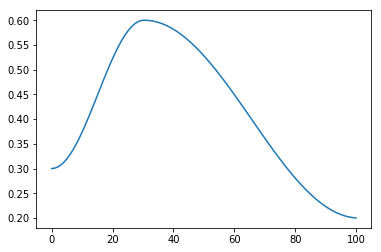

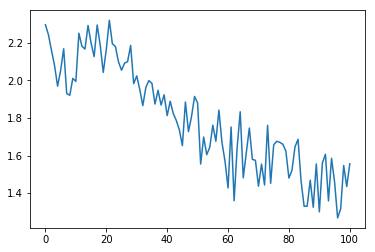

(None, None)

In [10]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## Adam: steppers=[adam_step]

In [11]:
model = get_cnn_model(layers_sizes, 3, out_features, conv_layer) 
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, opt=adam_opt(model.parameters(),lr=0.001), cb_funcs=cbfs)
%time learn.fit(1)

train: [26.481970780983403, tensor(0.1342)]
valid: [5.66271533203125, tensor(0.1020)]
CPU times: user 6min 42s, sys: 1min 23s, total: 8min 6s
Wall time: 1min 38s


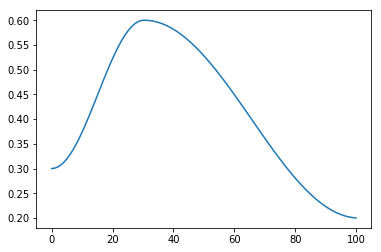

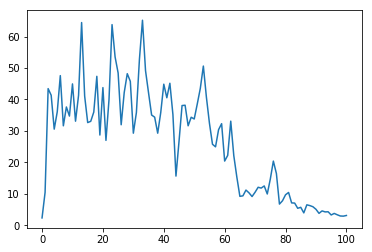

(None, None)

In [12]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## LAMB: steppers=[lamb_step]

In [13]:
model = get_cnn_model(layers_sizes, 3, out_features, conv_layer) 
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, opt=lamb(model.parameters(),lr=0.003), cb_funcs=cbfs)
%time learn.fit(1)

train: [300.4852644640918, tensor(0.1364)]
valid: [87.4201015625, tensor(0.1620)]
CPU times: user 6min 52s, sys: 1min 38s, total: 8min 31s
Wall time: 1min 45s


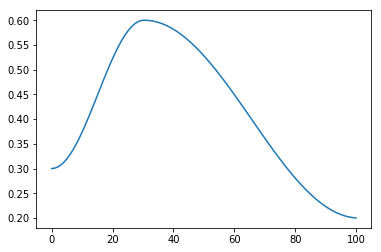

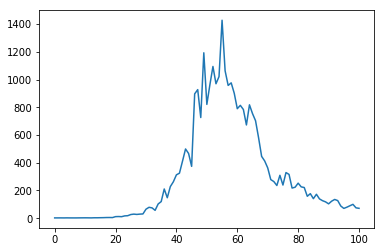

(None, None)

In [14]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## mnist with hooks

train: [33.589145145028695, tensor(0.1279)]
valid: [367.27496875, tensor(0.1440)]


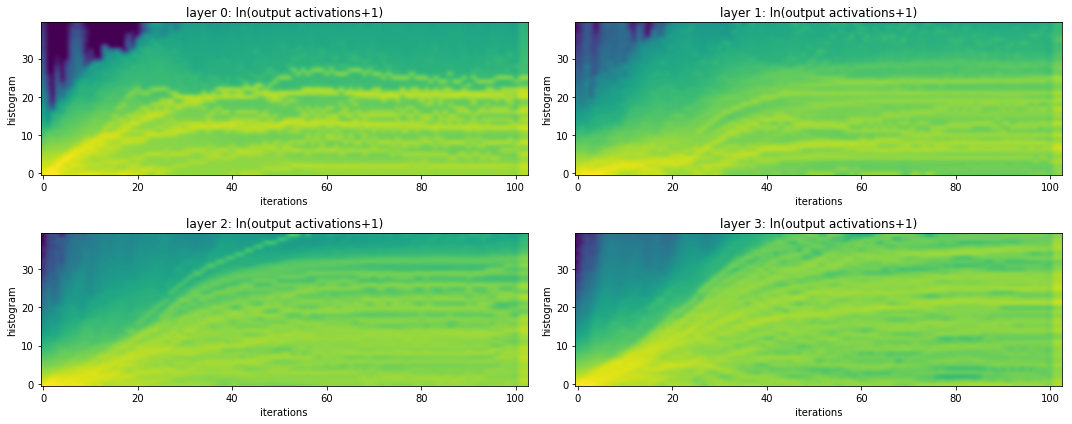

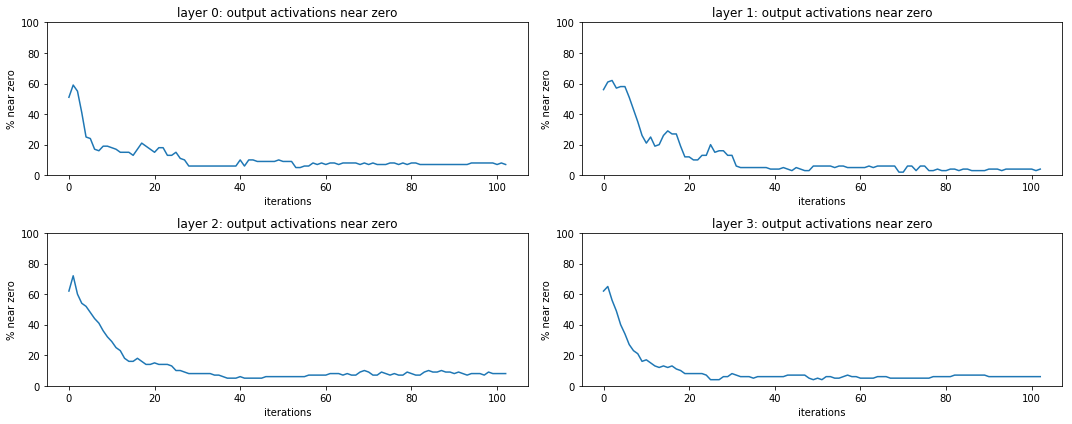

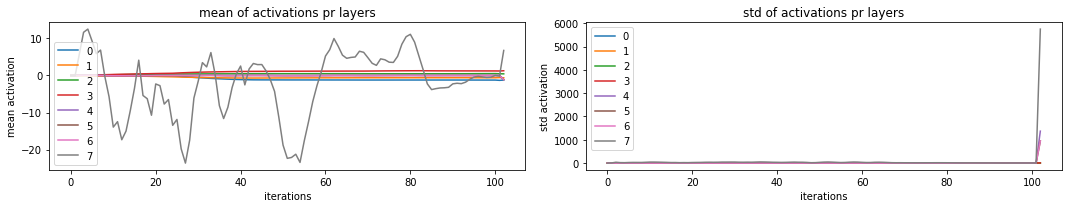

In [15]:
model = get_cnn_model(layers_sizes, 3, out_features, conv_layer) 
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, opt=adam_opt(model.parameters(),lr=0.001), cb_funcs=cbfs)
with Hooks(model, append_stats) as hooks: 
    learn.fit(1)
    plot_layer_stats( hooks )